In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
class TracerDataset(Dataset):
    def __init__(self, imdb_file, train=True):
        with open(imdb_file, "rb") as f:
            self.imdb = pickle.load(f)
            self.imdb = self.get_dataset_split(self.imdb, 1 if train else 2)
    
    def get_dataset_split(self, imdb, split_idx):
        return [x for x in imdb if x[1] == split_idx]
    
    def __len__(self):
        return len(self.imdb)

    def __getitem__(self, idx):
        img = torch.tensor(self.imdb[idx][0], dtype=torch.float32).T
        angle = torch.tensor(self.imdb[idx][2], dtype=torch.float32)
        return img, angle

class TracerNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(576, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        x = F.normalize(x, dim=1)
        return x

In [ ]:
def angle_to_vector(angle_deg):
    angle_rad = torch.deg2rad(angle_deg)
    return torch.stack([torch.cos(angle_rad), torch.sin(angle_rad)], dim=1)

In [53]:
train_loader = DataLoader(TracerDataset("Models/imdb_combined.pkl", train=True), batch_size=256)
val_loader = DataLoader(TracerDataset("Models/imdb_combined.pkl", train=True), batch_size=256)

In [92]:
def save_checkpoint(epoch, model, opt, val_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'val_loss': val_losses[-1]
    }
    torch.save(checkpoint, "latest.pth")
    best_val_loss = 99999
    if len(val_losses[:-1]): best_val_loss = min(val_losses[:-1])
    if val_losses[-1] < best_val_loss: 
        torch.save(checkpoint, "best.pth")

In [85]:
def plot_progress(train_losses, val_losses):
    plt.clf()
    plt.grid()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

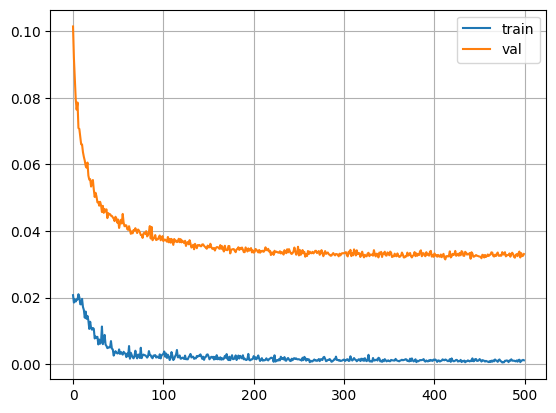

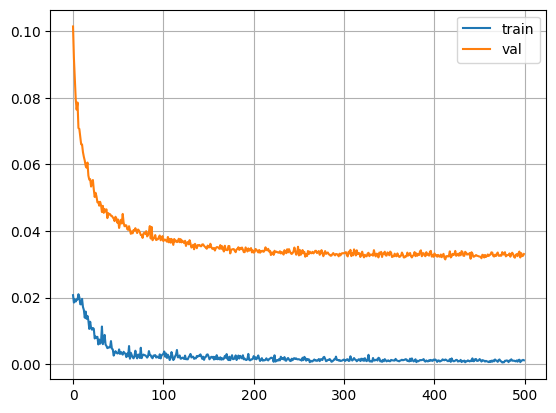

In [105]:

device = "cuda"
model = TracerNet()
model.to(device)

loss_func = F.mse_loss
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

train_losses = []
val_losses = []

epochs = 500
for epoch in range(epochs):
    model.train()
    t = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (x, y) in t:
        x = x.to(device)
        y = y.to(device)

        preds = model(x)

        targets = angle_to_vector(y).squeeze()
        loss = loss_func(preds, targets)

        loss.backward()
        opt.step()
        opt.zero_grad()
        t.set_description(f"Epoch {epoch+1} | Loss: {loss.item():02f}")
    model.eval()
    with torch.no_grad():
        val_loss = torch.tensor([loss_func(model(x.to(device)), angle_to_vector(y.to(device)).squeeze()) for x, y in val_loader]).mean()
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    save_checkpoint(epoch, model, opt, val_losses)
    plot_progress(train_losses, val_losses)



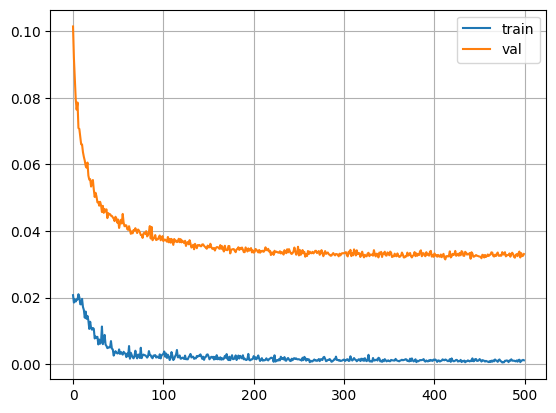

In [106]:
plt.clf()
plt.grid()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.savefig("bigger_net_1024_normalized.pdf")